<a href="https://colab.research.google.com/github/chandagrover/Machine-Learning/blob/master/2SMILEVAEGeneration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Basic Installs and**

In [1]:
!wget -c https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.8.3-Linux-x86_64.sh
!time bash ./Miniconda3-py37_4.8.3-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2020-09-21 09:32:36--  https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh [following]
--2020-09-21 09:32:36--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ | / - \ | / - \ | / - \ | failed w

In [2]:
# General Imports
import os
import pandas as pd
import numpy as np
import sklearn
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from matplotlib import pyplot as plt
import re

# **SMILES Data Fetching From Zinc Database**

In [3]:
WEIGHTS_FOLDER = 'sample_data/weights/'
smifile = "sample_data/AAAA.smi"
data = pd.read_csv(smifile, delimiter = " ", names = ["smiles","zinc_id"])
NUM_SMILES = len(data)
data["smiles"].head()


0                                     smiles
1                 Cn1cnc2c1c(=O)n(C)c(=O)n2C
2    O=C(O)[C@@H]1/C(=C/CO)O[C@@H]2CC(=O)N21
3                   Cn1c2nncnc2c(=O)n(C)c1=O
4                 Cn1cnc2c1c(=O)[nH]c(=O)n2C
Name: smiles, dtype: object

In [4]:
from sklearn.model_selection import train_test_split
smiles_train, smiles_test = train_test_split(data["smiles"])
print(smiles_train.shape)
print(smiles_test.shape)
print(NUM_SMILES)

(2844,)
(948,)
3792


In [5]:
charset = set("".join(list(data.smiles))+"!E")
char_to_int = dict((c,i) for i,c in enumerate(charset))
int_to_char = dict((i,c) for i,c in enumerate(charset))
# embed = max([len(smile) for smile in data.smiles]) + 5
embed = max([len(smile) for smile in data.smiles])+2
print(char_to_int)
print(len(charset), embed)
print(embed)

{'/': 0, '3': 1, '2': 2, '#': 3, 'o': 4, '\\': 5, 'l': 6, 'O': 7, 'N': 8, '6': 9, '+': 10, 'e': 11, '(': 12, ']': 13, 'c': 14, '1': 15, 'i': 16, 'F': 17, 'C': 18, 's': 19, 'S': 20, 'B': 21, '5': 22, 'E': 23, ')': 24, 'n': 25, '4': 26, '[': 27, 'm': 28, 'P': 29, 'H': 30, '-': 31, '@': 32, '=': 33, '!': 34}
35 58
58


In [6]:
print(type(smiles_train))
print(smiles_train.values[0])
print(len(smiles_train.values[0]))
print(type(smiles_train.values[0]))

<class 'pandas.core.series.Series'>
N[C@@H]1CNC(=O)C1
17
<class 'str'>


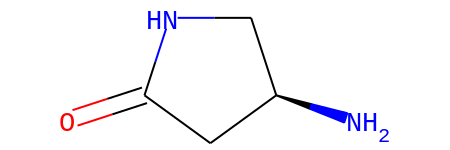

In [7]:
from rdkit.Chem.Draw import IPythonConsole
m = Chem.MolFromSmiles(smiles_train.values[0])
m

In [8]:
def vectorize(smiles):
        onehot_flatList=[[]]
        one_hot =  np.zeros((smiles.shape[0], embed , len(charset)),dtype=np.int8)
        print(one_hot.shape)
        for i,smile in enumerate(smiles):
            #encode the startchar
            one_hot[i,0,char_to_int["!"]] = 1
            #encode the rest of the chars
            for j,c in enumerate(smile):
                one_hot[i,j+1,char_to_int[c]] = 1
            #Encode endchar
            one_hot[i,len(smile)+1:,char_to_int["E"]] = 1
        #Return two, one for input and the other for output
        return one_hot[:,:,:]

X_train= vectorize(smiles_train.values)
X_test = vectorize(smiles_test.values)

(2844, 58, 35)
(948, 58, 35)


In [9]:
# Going back from vectorized form back to a readable string
strr="".join([int_to_char[idx] for idx in np.argmax(X_train[0,:,:], axis=1)])
print(strr)
print(len(strr))

# String After Tructation of extra symbols

line = re.sub('[!E]', '', strr)
print(len(line))
print(line)

!N[C@@H]1CNC(=O)C1EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
58
17
N[C@@H]1CNC(=O)C1


In [10]:
mol_size_x=X_train.shape[1]
mol_size_y=X_train.shape[2]
orig_dim = mol_size_x * mol_size_y
print(mol_size_x)
print(mol_size_y)
print(orig_dim)

58
35
2030


In [11]:
X_train = np.reshape(X_train, [-1, orig_dim])
X_test = np.reshape(X_test, [-1, orig_dim])
print(type(X_train))
print(X_train.shape)
print(X_train.shape[1])

<class 'numpy.ndarray'>
(2844, 2030)
2030


# **Building VAE Model Architecture**

In [12]:
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint 
from keras.utils import plot_model
from keras.losses import mse, binary_crossentropy

In [13]:
# Network Parameters
INPUT_DIM=(orig_dim,)   # SMILES dimension
intermediate_dim=512
BATCH_SIZE=2
Z_DIM=20 # Dimension of the latent vector (z)
epochs=50

### **Building the Encoder**

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 2030)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          1039872     encoder_input[0][0]              
__________________________________________________________________________________________________
mu (Dense)                      (None, 20)           10260       dense[0][0]                      
__________________________________________________________________________________________________
log_var (Dense)                 (None, 20)           10260       dense[0][0]                      
_______________________________________________________________________________________

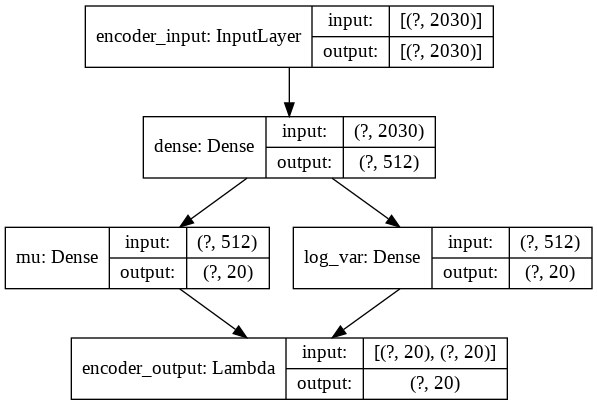

In [14]:
# ENCODER
def build_vae_encoder(input_dim, output_dim):
  
  # Clear tensorflow session to reset layer
  global K
  K.clear_session()
  
  # Define model input
  encoder_input = Input(shape = input_dim, name = 'encoder_input')
  
  #Intermediate layer
  x = Dense(intermediate_dim,activation='relu')(encoder_input)
 
  #Model Output
  mean_mu = Dense(output_dim, name = 'mu')(x)
  log_var = Dense(output_dim, name = 'log_var')(x)

  # Defining a function for sampling
  def sampling(args):
    mean_mu, log_var = args
    epsilon = K.random_normal(shape=K.shape(mean_mu), mean=0., stddev=1.) 
    return mean_mu + K.exp(log_var/2)*epsilon   
  
  # Using a Keras Lambda Layer to include the sampling function as a layer 
  # in the model
  encoder_output = Lambda(sampling, output_shape=(Z_DIM,), name='encoder_output')([mean_mu, log_var])

  return encoder_input, encoder_output, mean_mu, log_var, Model(encoder_input, encoder_output)

vae_encoder_input, vae_encoder_output,  mean_mu, log_var, vae_encoder  = build_vae_encoder(input_dim = INPUT_DIM,
                                                                                            output_dim = Z_DIM)
vae_encoder.summary()
# Plot the Encoder Model
plot_model(vae_encoder, to_file='smilesvae_encoder.png', show_shapes=True, show_layer_names=True, expand_nested=True)

In [15]:
print(type(vae_encoder_input))
print(type(vae_encoder_output))
print(type(vae_encoder))


<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.keras.engine.functional.Functional'>



### **Building the Decoder**

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 20)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               10752     
_________________________________________________________________
dense_2 (Dense)              (None, 2030)              1041390   
Total params: 1,052,142
Trainable params: 1,052,142
Non-trainable params: 0
_________________________________________________________________


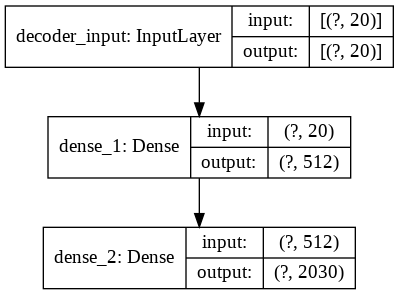

In [16]:

# Decoder
def build_decoder(input_dim, output_dim):

  # Define model input
  decoder_input = Input(shape = (input_dim,) , name = 'decoder_input')
  
  #Intermediate Layer
  x = Dense(intermediate_dim, activation='relu')(decoder_input)

    # Define model output
  decoder_output = Dense(output_dim, activation='sigmoid')(x)


  return decoder_input, decoder_output, Model(decoder_input, decoder_output)


vae_decoder_input, vae_decoder_output, vae_decoder = build_decoder(input_dim = Z_DIM, output_dim=orig_dim)
vae_decoder.summary()
# Plot the Encoder Model
plot_model(vae_decoder, to_file='smilesvae_decoder.png', show_shapes=True, show_layer_names=True, expand_nested=True)

### **Attaching Decoder to the Encoder**

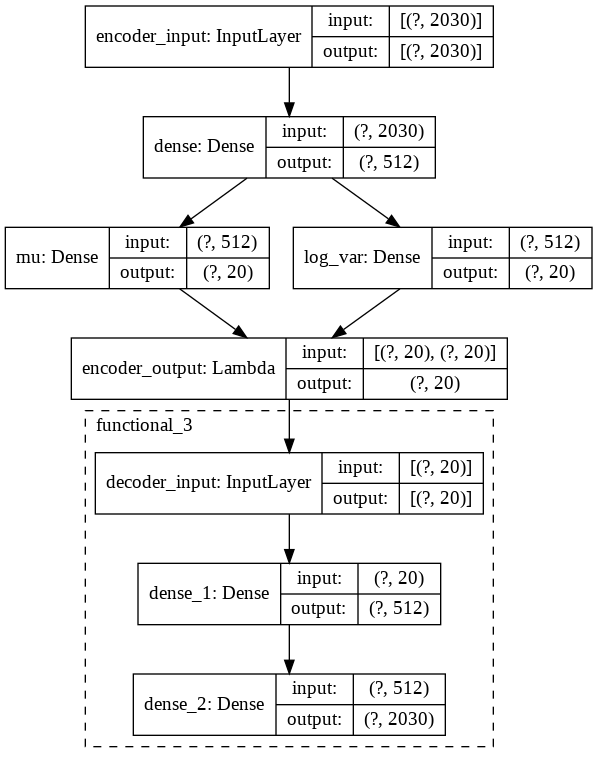

In [17]:
# The input to the model will be the smile string fed to the encoder.
vae_input = vae_encoder_input

# Output will be the output of the decoder. The term - decoder(encoder_output) 
# combines the model by passing the encoder output to the input of the decoder.
vae_output = vae_decoder(vae_encoder_output)

# Input to the combined model will be the input to the encoder.
# Output of the combined model will be the output of the decoder.
vae_model = Model(vae_input, vae_output)
# Plot the Encoder Model
plot_model(vae_model, to_file='smilesvae_model.png', show_shapes=True, show_layer_names=True, expand_nested=True)

### **Compiling and Training**

In [18]:
if __name__ == '__main__':
    models=(vae_encoder, vae_decoder)
    data=(X_test,X_test)

    reconstruction_loss = binary_crossentropy(vae_input, vae_output)
    reconstruction_loss = reconstruction_loss * orig_dim
    
    kl_loss = 1 + log_var - K.square(mean_mu) - K.exp(log_var)
    kl_loss = K.sum(kl_loss, axis=-1)    
    kl_loss = kl_loss * -0.5
    
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae_model.add_loss(vae_loss)
    vae_model.compile(optimizer='adam')
    
    
    
#     Train the Variational AutoEncoder
    vae_model.fit(X_train, epochs=epochs, batch_size=BATCH_SIZE, validation_data=(X_test, None))
    vae_model.save_weights('vae_smiles.h5')
    
    

Epoch 1/50
1422/1422 [==============================] - 7s 5ms/step - loss: 107.0425 - val_loss: 80.0542
Epoch 2/50
1422/1422 [==============================] - 7s 5ms/step - loss: 73.5276 - val_loss: 71.0199
Epoch 3/50
1422/1422 [==============================] - 7s 5ms/step - loss: 66.3901 - val_loss: 66.1853
Epoch 4/50
1422/1422 [==============================] - 7s 5ms/step - loss: 62.1031 - val_loss: 64.3273
Epoch 5/50
1422/1422 [==============================] - 7s 5ms/step - loss: 58.8883 - val_loss: 62.7553
Epoch 6/50
1422/1422 [==============================] - 7s 5ms/step - loss: 56.5915 - val_loss: 60.3378
Epoch 7/50
1422/1422 [==============================] - 7s 5ms/step - loss: 54.4159 - val_loss: 59.8751
Epoch 8/50
1422/1422 [==============================] - 7s 5ms/step - loss: 52.6864 - val_loss: 59.2804
Epoch 9/50
1422/1422 [==============================] - 7s 5ms/step - loss: 51.0127 - val_loss: 58.2571
Epoch 10/50
1422/1422 [==============================] - 7s 5ms

In [19]:
reconst_Xtest = vae_model.predict(X_test, batch_size=BATCH_SIZE)
print(type(reconst_Xtest))

<class 'numpy.ndarray'>


### **Reconstructing Test Data Molecules**

In [20]:
reconst_Xtest = vae_model.predict(X_test, batch_size=BATCH_SIZE)
print(type(reconst_Xtest))
print(reconst_Xtest.shape)
print(X_test.shape)
reconst_test = reconst_Xtest.reshape(len(X_test), mol_size_x,mol_size_y)
test=X_test.reshape(len(X_test), mol_size_x, mol_size_y)
print(reconst_test.shape)
print(test.shape)

<class 'numpy.ndarray'>
(948, 2030)
(948, 2030)
(948, 58, 35)
(948, 58, 35)


!Nc1c[nH]c(=O)nc1NEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
58
Nc1c[nH]c(=O)nc1N
17


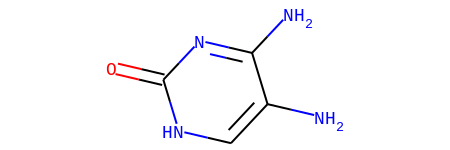

In [21]:
# Going back from vectorized form back to a readable string
idx=15
temp_str="".join([int_to_char[idx] for idx in np.argmax(test[idx,:,:], axis=1)])
print(temp_str)
print(len(temp_str))
temp_str = re.sub('!|E',"", temp_str)
print(temp_str)
print(len(temp_str))

m = Chem.MolFromSmiles(temp_str)
m

!Nc1n[nH]c(=O)nc1NEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
58
Nc1n[nH]c(=O)nc1N
17


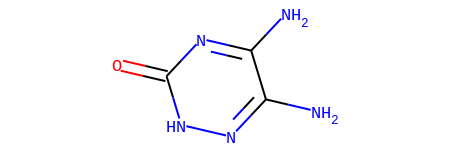

In [22]:
# Going back from vectorized form back to a readable string
temp_str="".join([int_to_char[idx] for idx in np.argmax(reconst_test[idx,:,:], axis=1)])
print(temp_str)
print(len(temp_str))
temp_str = re.sub('!|E',"", temp_str)
print(temp_str)
print(len(temp_str))

m = Chem.MolFromSmiles(temp_str)
m

# **Generating new Molecules from random latent vector sampled from standard normal distribution**

RDKit ERROR: [09:58:28] SMILES Parse Error: syntax error while parsing: O=C(O)C[C@@]1(C(OO)C[C](C)[[C@H]OCO@H]
RDKit ERROR: [09:58:28] SMILES Parse Error: Failed parsing SMILES 'O=C(O)C[C@@]1(C(OO)C[C](C)[[C@H]OCO@H]' for input: 'O=C(O)C[C@@]1(C(OO)C[C](C)[[C@H]OCO@H]'
RDKit ERROR: [09:58:28] SMILES Parse Error: syntax error while parsing: N[C@H](O)[C@H](N)C[C[CC(H]1O
RDKit ERROR: [09:58:28] SMILES Parse Error: Failed parsing SMILES 'N[C@H](O)[C@H](N)C[C[CC(H]1O' for input: 'N[C@H](O)[C@H](N)C[C[CC(H]1O'
RDKit ERROR: [09:58:28] SMILES Parse Error: syntax error while parsing: OCC1NCC=OC[C@H](C)[C@@H
RDKit ERROR: [09:58:28] SMILES Parse Error: Failed parsing SMILES 'OCC1NCC=OC[C@H](C)[C@@H' for input: 'OCC1NCC=OC[C@H](C)[C@@H'
RDKit ERROR: [09:58:28] SMILES Parse Error: extra close parentheses while parsing: NCCNNC=O)(C=CC
RDKit ERROR: [09:58:28] SMILES Parse Error: Failed parsing SMILES 'NCCNNC=O)(C=CC' for input: 'NCCNNC=O)(C=CC'
RDKit ERROR: [09:58:28] SMILES Parse Error: syntax error

invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES


RDKit ERROR: [09:58:28] SMILES Parse Error: syntax error while parsing: OCC(N)CN1C]1)CCN1
RDKit ERROR: [09:58:28] SMILES Parse Error: Failed parsing SMILES 'OCC(N)CN1C]1)CCN1' for input: 'OCC(N)CN1C]1)CCN1'
RDKit ERROR: [09:58:28] SMILES Parse Error: syntax error while parsing: O=CNc==O)[CH](]1NNCC@H
RDKit ERROR: [09:58:28] SMILES Parse Error: Failed parsing SMILES 'O=CNc==O)[CH](]1NNCC@H' for input: 'O=CNc==O)[CH](]1NNCC@H'
RDKit ERROR: [09:58:28] SMILES Parse Error: extra open parentheses for input: 'NC(=O)CC(=O1C1CCNCC11=N'
RDKit ERROR: [09:58:28] SMILES Parse Error: syntax error while parsing: NCC(@H]1CC@H](N(CO)(=O)S
RDKit ERROR: [09:58:28] SMILES Parse Error: Failed parsing SMILES 'NCC(@H]1CC@H](N(CO)(=O)S' for input: 'NCC(@H]1CC@H](N(CO)(=O)S'
RDKit ERROR: [09:58:28] SMILES Parse Error: syntax error while parsing: OC[C@@H](O)[C@H](O)C1OCO(O)(C@[OOO
RDKit ERROR: [09:58:28] SMILES Parse Error: Failed parsing SMILES 'OC[C@@H](O)[C@H](O)C1OCO(O)(C@[OOO' for input: 'OC[C@@H](O)[C@H](

invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES


RDKit ERROR: [09:58:28] SMILES Parse Error: syntax error while parsing: OC(=O)c(C(=O[[nH]]1N)C1
RDKit ERROR: [09:58:28] SMILES Parse Error: Failed parsing SMILES 'OC(=O)c(C(=O[[nH]]1N)C1' for input: 'OC(=O)c(C(=O[[nH]]1N)C1'


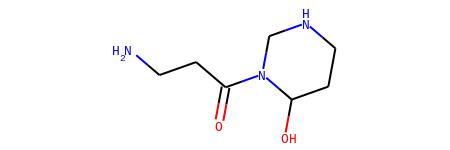

In [40]:
# Generating new Smile Strings sampled from a standard normal distribution
m=None
while m is None:
  reconst_strings = vae_decoder.predict(np.random.normal(0,1,size=(10,Z_DIM)))
  reshaped_string=reconst_strings.reshape(10, mol_size_x, mol_size_y)

  # Going back from vectorized form back to a readable string
  temp_str="".join([int_to_char[idx] for idx in np.argmax(reshaped_string[0,:,:], axis=1)])
  temp_str = re.sub('!|E',"", temp_str)

  m = Chem.MolFromSmiles(temp_str, sanitize=False)
  if m is None:
    print('invalid SMILES')
    continue                   
  else:
    try:
     p = Chem.SanitizeMol(m)
    except:
      print('invalid chemistry') #
m



# **Visualizing Latent Space**

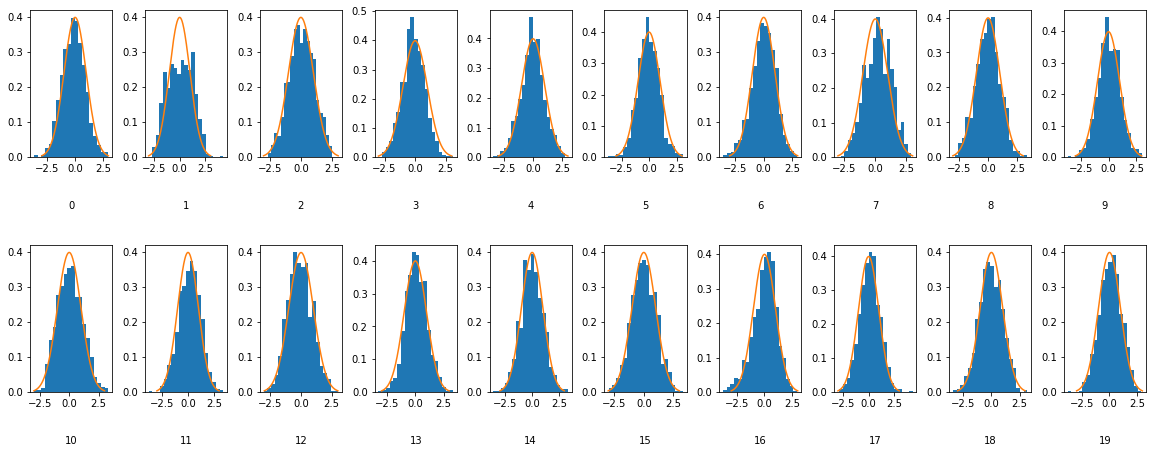

In [24]:
from scipy.stats import norm

z_test = vae_encoder.predict(X_test)

x = np.linspace(-3, 3, 300)

fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(20):
    ax = fig.add_subplot(5, 10, i+1)
    ax.hist(z_test[:,i], density=True, bins = 20)
    ax.axis('on')
    ax.text(0.5, -0.35, str(i), fontsize=10, ha='center', transform=ax.transAxes)
    ax.plot(x,norm.pdf(x))

plt.show()

[[-1.0289582   0.12553674  0.4141824  ... -1.2272892   1.258335
   2.293593  ]
 [-1.0804858  -0.53923047 -0.949202   ... -0.27948362  0.948047
   0.73725957]
 [-0.7142334   1.9852629   0.04465014 ... -0.19369698 -0.68128705
  -0.47175485]
 ...
 [-0.24073732 -1.8634703   1.075451   ...  0.56330633  0.07211225
  -0.7443596 ]
 [-0.5911685  -0.48681897  0.7969868  ... -0.586694    2.8327973
   0.21782967]
 [ 0.01204041  0.08299953  0.24093461 ...  0.08840889  0.51331866
   0.4932932 ]]


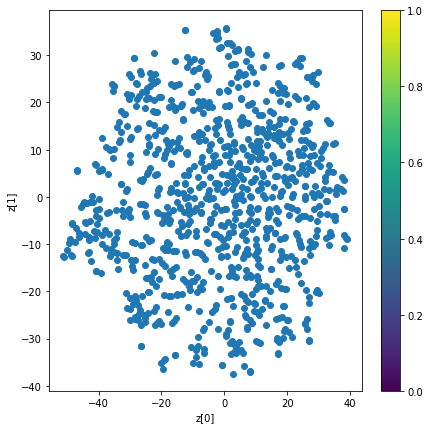

In [25]:
from sklearn.manifold import TSNE
z_mean = vae_encoder.predict(X_test)
print(z_mean)
model_name='VAESMILES_Latent'
os.makedirs(model_name, exist_ok=True)
filename = os.path.join(model_name, "smilesvae_mean.png")

z_embedded = TSNE(n_components=2).fit_transform(z_mean)
plt.figure(figsize=(7,7))
plt.scatter(z_embedded[:, 0], z_embedded[:, 1])
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.savefig(filename)
plt.show()

In [26]:
print(z_mean.shape)
print(z_embedded.shape)

(948, 20)
(948, 2)
